In [1]:
import numpy as np
import sys
sys.path.append("../01_code/")
from matplotlib import pyplot as plt
from MiyamotoNagaiPotential import *

In [2]:
def action_integration_F(t,y,ham):
    Ndof = ham.N_dof
    F = np.zeros(ham.N_dim + 1)
    F[:-1] = ham.flow_func(*y[:-1]).reshape(-1)
    F[-1] = (0.25/np.pi) * np.sum([y[i+Ndof]*F[i]-y[i]*F[i+Ndof]  for i in range(Ndof)])
    return F

In [3]:
NL,Na,Nb = 3,3,0.3
Rc = MiyamotoNagai_L_to_Rc(NL,Na,Nb)
ham = MiyamotoNagai_get_hamiltonian([Rc,0.,0.,0.],NL,Na,Nb)
vc = NL/Rc
Npts = 50
pz0s = vc * np.linspace(0.01,0.2,Npts)
Omega_z_numerical = np.zeros(Npts)
Jz_numerical = np.zeros(Npts)
ics = np.zeros((Npts,ham.N_dim))
for i,pz0 in enumerate(pz0s):
    ic,nu = MiyamotoNagai_find_vertical_periodic_orbit(pz0,ham)
    ics[i] = ic
    Omega_z_numerical[i] = nu
    period = 2*np.pi / nu
    soln=solve_ivp(
        action_integration_F,
        (0,period),
        np.concatenate((ic,(0,))),
        args=(ham,)
    )
    Jz_numerical[i] = soln.y[-1,-1]

In [4]:
def get_xseries(N):
    xseries_list = []
    for i in range(N):
        zeros = np.zeros(N,dtype = int)
        oi = zeros.copy()
        oi[i] = 1
        xseries = defaultdict(lambda: PoissonSeries(N,0))
        xseries[1] = PoissonSeries.from_PSTerms([PSTerm(1,oi,zeros,[],[])])
        xseries_list.append(xseries)
    return xseries_list

def get_pertubative_solution(ic,Rc,hav_series,chi_series,times):
    
    R0,z0,pR0,pz0 = ic
    kappa0 = hav_series[2][(1,0,1,0)]
    nu0 = hav_series[2][(0,1,0,1)]
    xR0 = np.sqrt(0.5*kappa0) * ((R0-Rc) + 1j * pR0 / kappa0)
    xz0 = np.sqrt(0.5*nu0) * (z0 + 1j * pz0 / nu0)

    xR_series,xz_series = get_xseries(2)
    f = pert_series_to_PoissonSeries
    hav = f(hav_series)
    
    xR_osc_to_mean = f(expLinv(xR_series,chi_series))
    xz_osc_to_mean = f(expLinv(xz_series,chi_series))
    
    xR_mean_to_osc = f(expL(xR_series,chi_series))
    xz_mean_to_osc = f(expL(xz_series,chi_series))
    
    xR_mean0 = xR_osc_to_mean([xR0,xz0],[],[])
    xz_mean0 = xz_osc_to_mean([xR0,xz0],[],[])
    
    xRdot_series = bracket(xR_series[1],hav)    
    R_freq_terms = [PSTerm(1j * term.C,term.k-np.array((1,0)),term.kbar,term.p,term.q) for term in xRdot_series.terms]
    R_freq = PoissonSeries.from_PSTerms(R_freq_terms)    
    kappa = R_freq([xR_mean0,xz_mean0],[],[])
    
    xzdot_series = bracket(xz_series[1],hav)
    z_freq_terms = [PSTerm(1j * term.C,term.k-np.array((0,1)),term.kbar,term.p,term.q) for term in xzdot_series.terms]
    z_freq = PoissonSeries.from_PSTerms(z_freq_terms)    
    nu = z_freq([xR_mean0,xz_mean0],[],[])
    
    xR_osc,xz_osc = np.zeros((2,len(times)),dtype = np.complex128)
    
    
    for i,t in enumerate(times):
        xR = xR_mean0 * np.exp(-1j * kappa * t)
        xz = xz_mean0 * np.exp(-1j * nu * t)
        xR_osc[i] = xR_mean_to_osc([xR,xz],[],[])
        xz_osc[i] = xz_mean_to_osc([xR,xz],[],[])
    Rsoln = Rc + np.real(xR_osc)/np.sqrt(0.5*kappa0)
    zsoln = np.real(xz_osc)/np.sqrt(0.5*nu0)
    pRsoln = kappa0 * np.imag(xR_osc)/np.sqrt(0.5*kappa0)
    pzsoln = nu0 * np.imag(xz_osc)/np.sqrt(0.5*nu0)
    return np.real(np.transpose((Rsoln,zsoln,pRsoln,pzsoln))).astype(float)
        

def pert_series_to_PoissonSeries(pert_series,lmax = None):
    if not lmax:
        lmax = np.inf
    full_series = PoissonSeries(2,0)
    for order,series in pert_series.items():
        if order <= lmax:
            full_series += series
    return full_series

def collect_by_rt_action_power(series,indx):
    rtJ_coeffs = defaultdict(list)
    for term in series.terms:
        powr = term.k[indx] + term.kbar[indx]
        rtJ_coeffs[powr].append(term)
    return {pwr:PoissonSeries.from_PSTerms(term_list) for pwr,term_list in rtJ_coeffs.items()}

def h_series_to_omega_series(H_series):
    N = H_series.N
    Omega_term_lists = [[] for i in range(N)]
    oi = np.eye(N,dtype=int)
    for term in H_series.terms:
        C,k,kbar = term.C,term.k,term.kbar
        for i in range(N):
            if k[i]>0:
                Oterm = PSTerm(k[i] * C,kbar - oi[i],kbar - oi[i],[],[])
                Omega_term_lists[i].append(Oterm)
    return [PoissonSeries.from_PSTerms(term_list) for term_list in Omega_term_lists]

def ic_to_xs(ic,Rc,omega):
    R,z,pR,pz = ic
    kappa,nu = omega
    xR = np.sqrt(0.5 * kappa) * ((R-Rc) + 1j * pR/kappa)
    xz = np.sqrt(0.5 * nu) * (z + 1j * pz/nu)
    return xR,xz

In [6]:
from potentials_autodiff import get_derivs_func_dict, PotentialDerivativesToPoissonSeries
from celmech.poisson_series import do_perturbation_theory
from celmech.poisson_series import PoissonSeries,PSTerm
from celmech.poisson_series import expL,expLinv, bracket

lmax = 8

R,z,pR,pz = ham.qp_vars
rule = {R:Rc,z:0.,pR:0.,pz:0.}
derivs = dict()
for n in range(2,lmax+1):
    for l in range(n+1):
        nR = n-l
        nz = l
        derivs[(nR,nz)]=sp.diff(ham.N_H,R,nR,z,nz).xreplace(rule)


ham_series = PotentialDerivativesToPoissonSeries(derivs,lmax)
omega = np.real((ham_series[2][(1,0,1,0)],ham_series[2][(0,1,0,1)]))
chi,hav,_ = do_perturbation_theory(omega,ham_series,lmax)

Omega_R,Omega_z = h_series_to_omega_series(pert_series_to_PoissonSeries(hav))

xR_series,xz_series = get_xseries(2)
xz_mean_to_osc = pert_series_to_PoissonSeries(expL(xz_series,chi))
xR_mean_to_osc = pert_series_to_PoissonSeries(expL(xR_series,chi))

xR_series,xz_series = get_xseries(2)
xz_osc_to_mean = pert_series_to_PoissonSeries(expLinv(xz_series,chi))
xR_osc_to_mean = pert_series_to_PoissonSeries(expLinv(xR_series,chi))

In [8]:
from scipy.interpolate import pade
Omega_z_by_rtJz = collect_by_rt_action_power(Omega_z,1)

nu0 = np.real(hav[2][(0,1,0,1)])

In [9]:
lmax//2

4

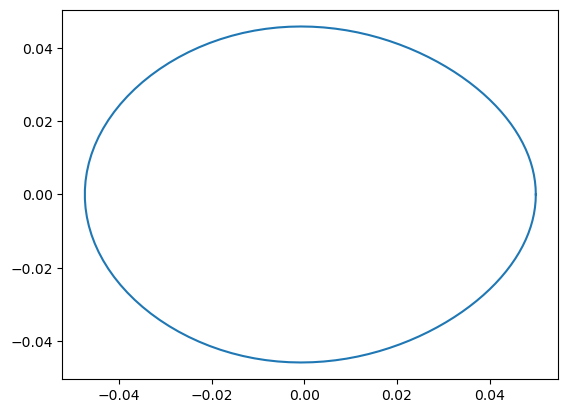

In [10]:
Jz_N = Jz_numerical[15]
xz_osc_data =np.array([xz_mean_to_osc([np.sqrt(Jz_N) * np.exp(1j * phi)],[],[]) for phi in np.linspace(0,2*np.pi,128)])

plt.plot(np.real(xz_osc_data),np.imag(xz_osc_data))

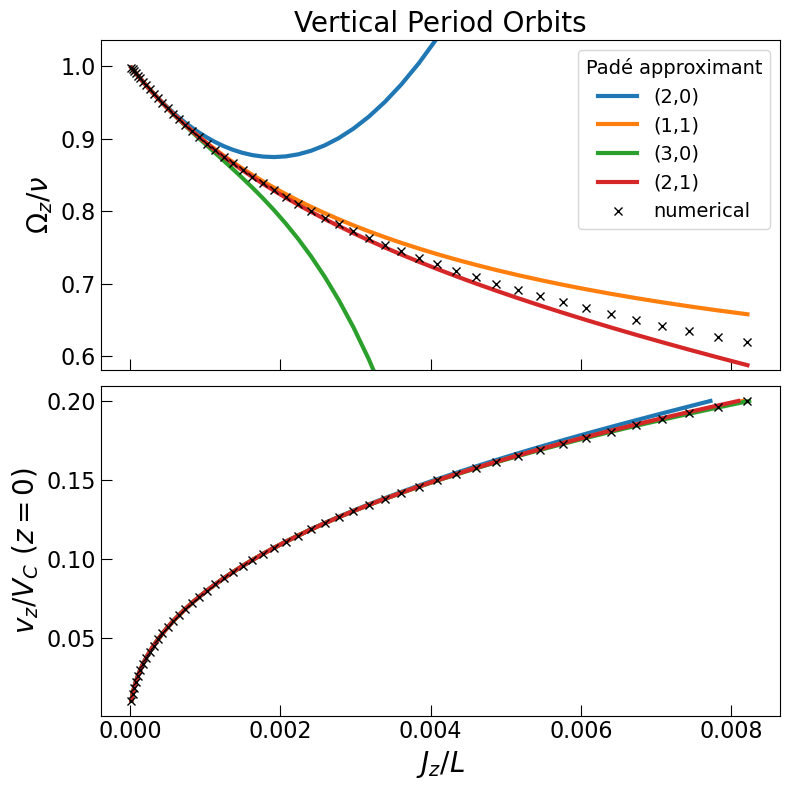

In [9]:
fig,ax = plt.subplots(2,1,sharex = True,figsize=(8,8))
for l in [6,8]:
    for m in range(2):
        p,q = pade([Omega_z_by_rtJz[2*i]([0,1],[],[]) for i in range(l//2)],m=m)
        Omega_z_pade = np.real(p(Jz_numerical)/q(Jz_numerical))
        ax[0].plot(Jz_numerical/NL,Omega_z_pade/nu0,label="({},{})".format(l//2-1-m,m),lw=3)
ax[0].plot(Jz_numerical/NL,Omega_z_numerical/nu0,'kx',label="numerical",zorder=99)
legend = ax[0].legend(title="Padé approximant",fontsize=14)
plt.setp(legend.get_title(),fontsize=14)

ymin,ymax=np.min(Omega_z_numerical/nu0),np.max(Omega_z_numerical/nu0)
dy = ymax - ymin
ax[0].set_ylim(ymin - 0.1 * dy,ymax + 0.1 * dy)

ax[0].set_ylabel(r"$\Omega_z/\nu$",fontsize=20)

xz_osc_to_mean_by_rtJz = collect_by_rt_action_power(xz_osc_to_mean,1)
phase = np.pi/2
Z = np.exp(1j*phase)
for l in [6,8]:
    for m in range(2):
        Jz_means = np.zeros(Npts)
        for i,ic in enumerate(ics):
            xR,xz = ic_to_xs(ic,Rc,omega)
            p,q = pade([xz_osc_to_mean_by_rtJz[2*i+1]([xR,Z],[],[]) for i in range(l//2)],m)
            Jz_osc = xz *np.conj(xz)
            xz_pade = np.sqrt(Jz_osc) * p(Jz_osc)/q(Jz_osc)
            Jz_means[i] = np.abs(xz_pade)**2
        ax[1].plot(Jz_means/NL,pz0s/vc,label="({},{})".format(l//2-1-m,m),lw=3)
ax[1].plot(Jz_numerical/NL,pz0s/vc,'kx')
ax[1].set_xlabel("$J_z/L$",fontsize=20)
ax[1].set_ylabel("$v_z/V_C~(z=0)$",fontsize=20)

for a in ax:
    plt.sca(a)
    plt.tick_params(direction='in',size=8,labelsize=16)
plt.subplots_adjust(hspace=0.025)
ax[0].set_title("Vertical Period Orbits",fontsize=20)
plt.tight_layout()
#plt.savefig("../03_figures/mn_vpo.png")

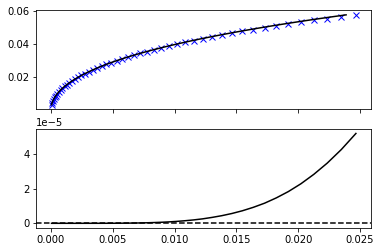

In [12]:
xz_means = np.zeros(Npts,dtype=np.complex128)
xR_means = np.zeros(Npts,dtype=np.complex128)
xz_osc = np.zeros(Npts,dtype=np.complex128)
xR_osc = np.zeros(Npts,dtype=np.complex128)
xz_osc_alt = np.zeros(Npts,dtype=np.complex128)
xR_osc_alt = np.zeros(Npts,dtype=np.complex128)
for i,ic in enumerate(ics):
    x_osc = ic_to_xs(ic,Rc,omega)
    xz_means[i] = xz_osc_to_mean(x_osc,[],[])
    xR_means[i] = xR_osc_to_mean(x_osc,[],[])
    xz_osc_alt[i] = xz_mean_to_osc([xR_means[i],xz_means[i]],[],[])
    xR_osc_alt[i] = xR_mean_to_osc([xR_means[i],xz_means[i]],[],[])
    xR_osc[i],xz_osc[i] = x_osc

fig,ax=plt.subplots(2,1,sharex=True)
ax[0].plot(Jz_numerical,pz0s,'bx')
ax[0].plot(np.real(xz_means * np.conjugate(xz_means)),pz0s,'k-')
ax[1].plot(Jz_numerical,np.real(xR_means * np.conjugate(xR_means)),'k-')
ax[1].axhline(0,color='k',ls='--')

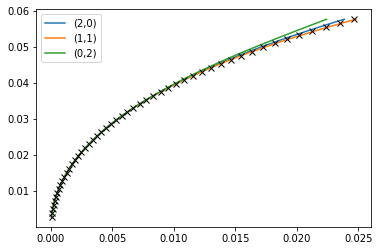